In [1]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings

# Task 5 - Classification 

## Load settings

In [2]:
grid = None
k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task5"
db_set = "datasets/cancerWTrain.mat"
filedir = "/home/fredrik/Documents/Learning_systems/Labs/Project/"
#filedir = "C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/"

scoring='accuracy' # Scoring method for GridsearchCV
score_function = f_classif # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [3]:
# Define models that should be trained
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[LinearSVC()],
        'clf__penalty':['l1','l2'],
        'clf__C': [0.1,0.5,1,1.5,2.0],
        'clf__dual':[True,False]
    },{
        'clf':[SVC()],
        'clf__C':[1,0.5,1,5.2],
        'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__degree':[1,2,3],
        'clf__gamma':['scale', 'auto'],
        'clf__max_iter':[1000,5000,10000],
    },{
        'clf':[RandomForestClassifier()],
        'clf__n_estimators':[100,150,200],
    },{
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':[5,3,6,8],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'clf__leaf_size':[30,15,20,40]
    },{
        'clf':[MLPClassifier()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu', 'tanh', 'logistic'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [4]:
mat = loadmat(db_set)
input_train = mat['cancerTrainX'].T

target_train = mat['cancerTrainY'].reshape(len(input_train))
input_test = mat['cancerTestX'].T

## Data info

In [5]:
get_data_info(input_train, target_train)

Length of 400
X.shape: (400, 30) y.shape: (400,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [6]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

Length of input: 400


## Feature distribution

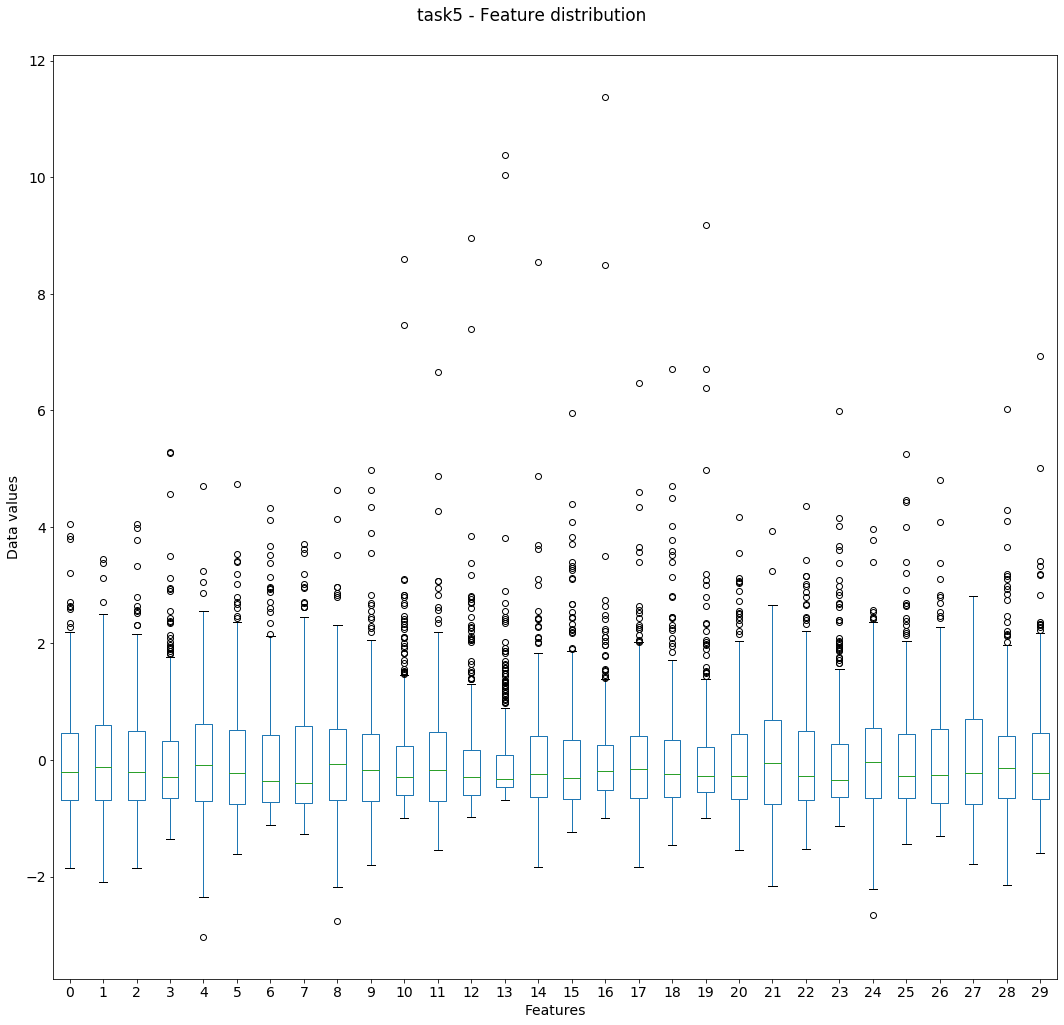

In [7]:
plot_feature_distribution(input_train, filedir=filedir, taskname=taskname)

## Feature reduction
Reduce dimensionality by PCA transform

In [8]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (400, 30)
transformed shape: (400, 10)
Explained variance: [0.44051208 0.19241213 0.09610965 0.06561167 0.04912958 0.04018143
 0.02397297 0.01747592 0.01477238 0.01229828]


## Feature extraction

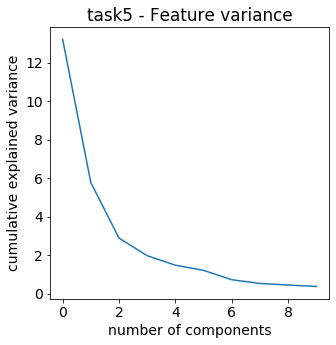

In [9]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Feature selection
Extract top features above depending on PCA

[ 0  2  3  6  7 20 22 23 26 27]
Shape of input: (400, 30)


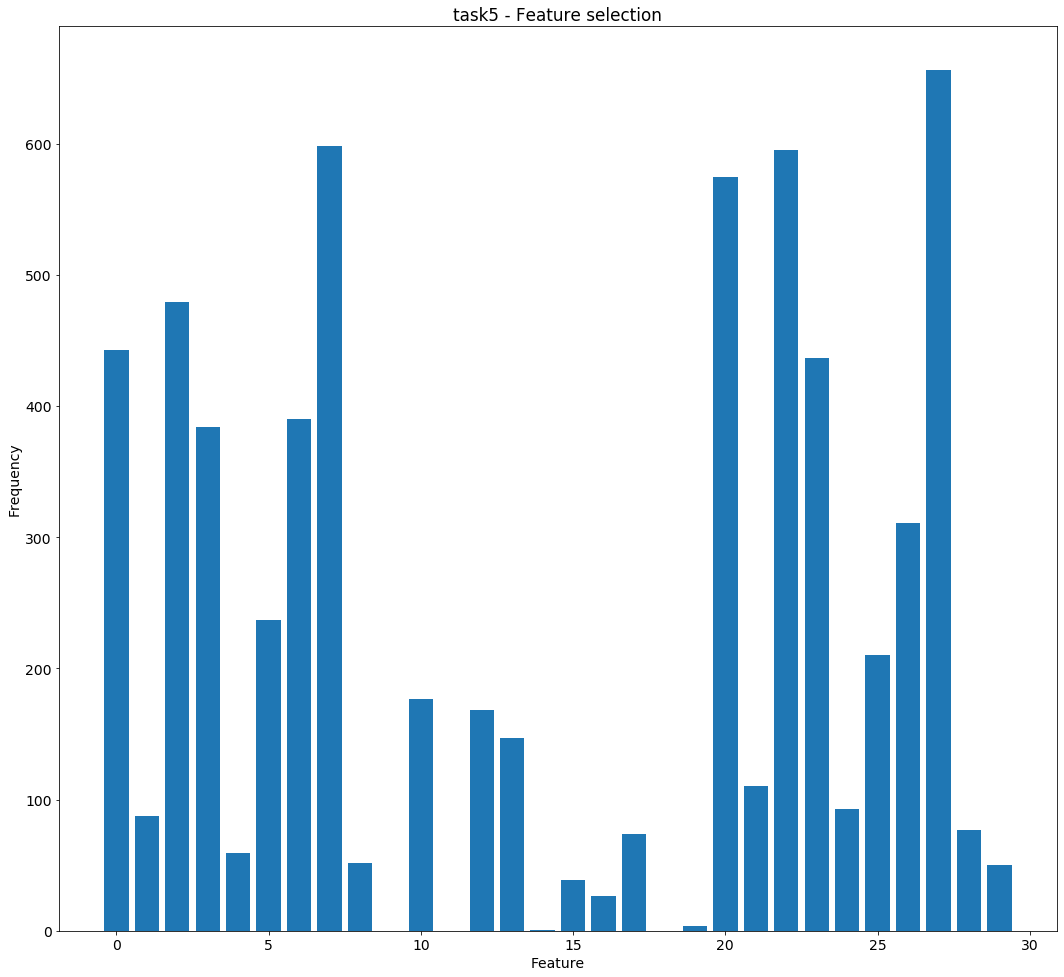

In [10]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname,feature_tot=feature_tot)

## Feature Relationship

x-axis contain features and y is frequency of values


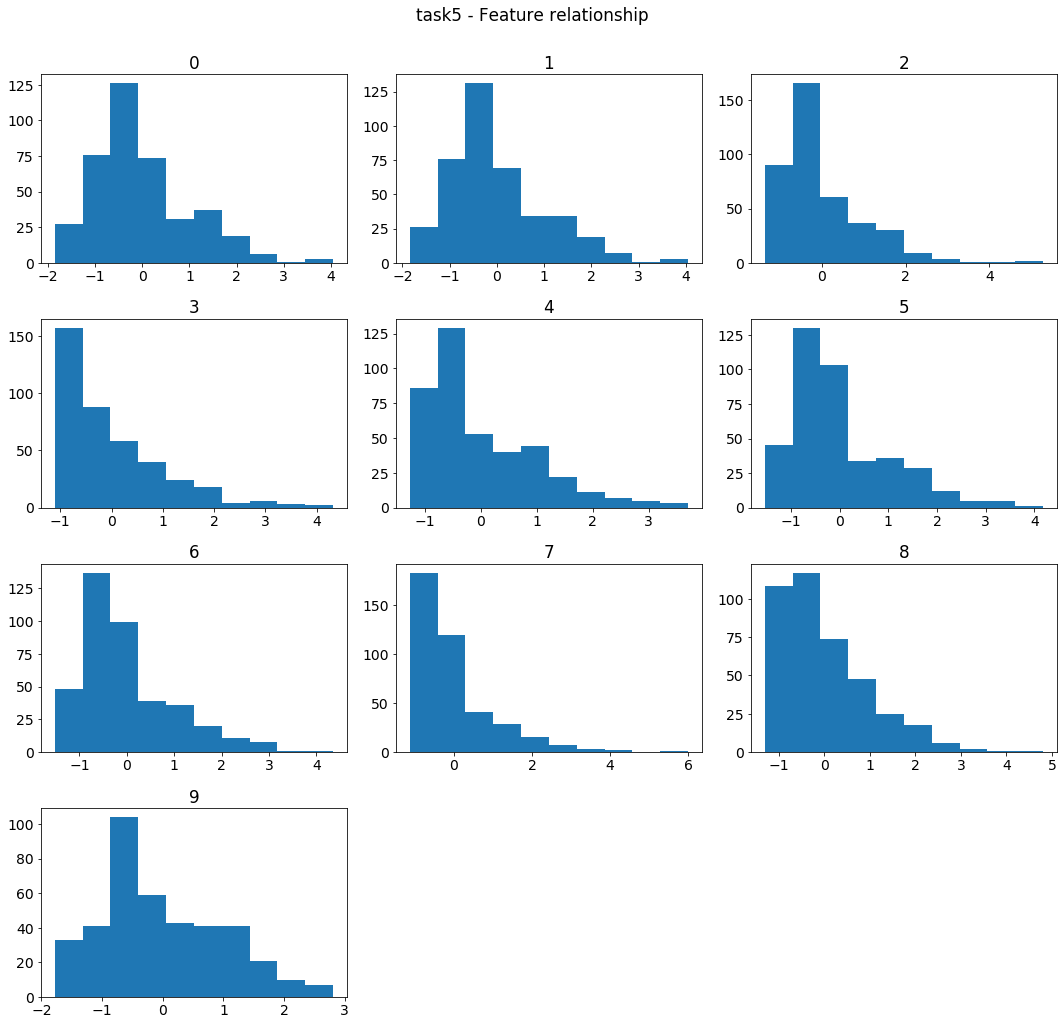

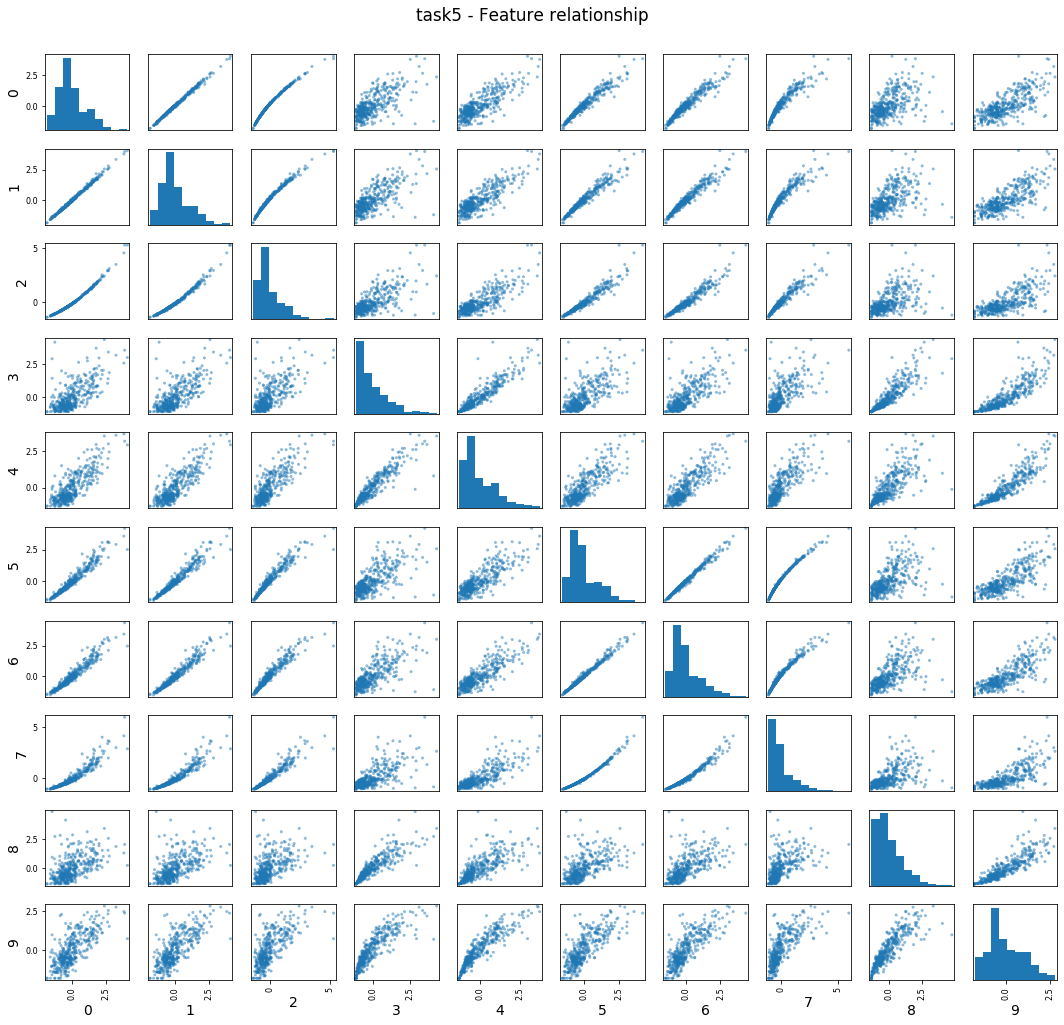

In [11]:
plot_feature_relationship(input_train_fs, filedir, taskname)

## Hyperparameter tuning

In [31]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 447 candidates, totalling 4470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 3032 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 3554 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4104 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 4470 out of 4470 | elapsed: 21.4min finished


## Save model

In [32]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: /home/fredrik/Documents/Learning_systems/Labs/Project/Models/task5.joblib


## Load model

In [12]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

Loading model:  /home/fredrik/Documents/Learning_systems/Labs/Project/Models/task5.joblib


## Get Model info

In [13]:
get_model_info(grid)

     mean_test_score  std_test_score  rank_test_score  \
278           0.9625        0.032113                1   
379           0.9625        0.032113                1   
256           0.9625        0.032113                1   
255           0.9625        0.032113                1   
254           0.9625        0.032113                1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

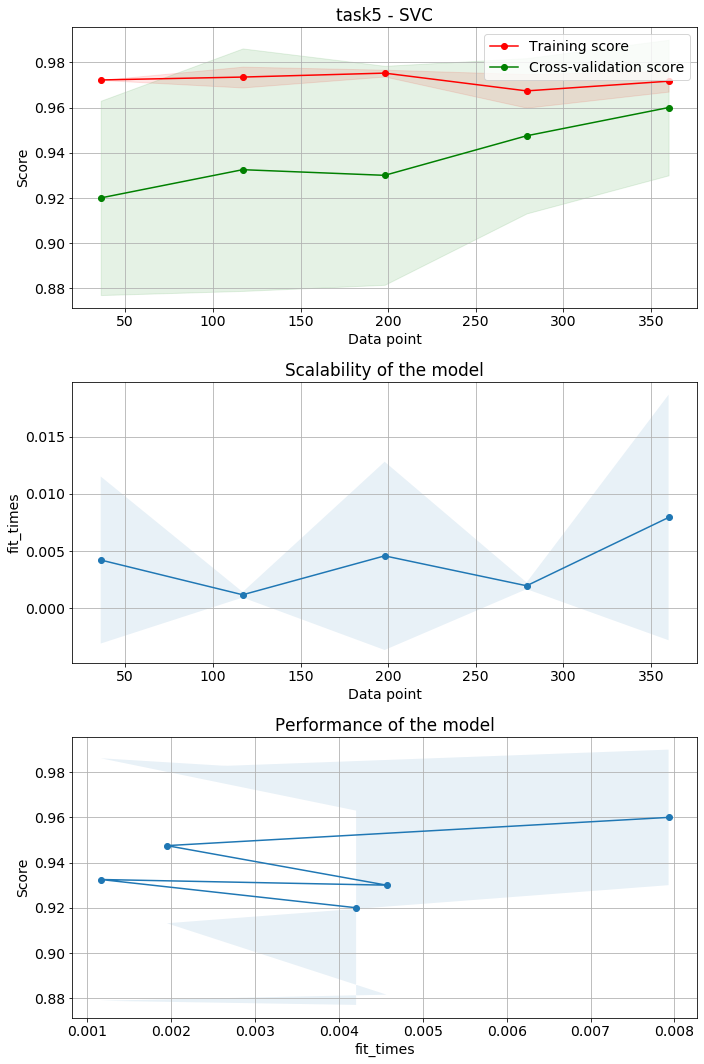

In [14]:
validate_curve(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname,scoring=scoring, k=k)

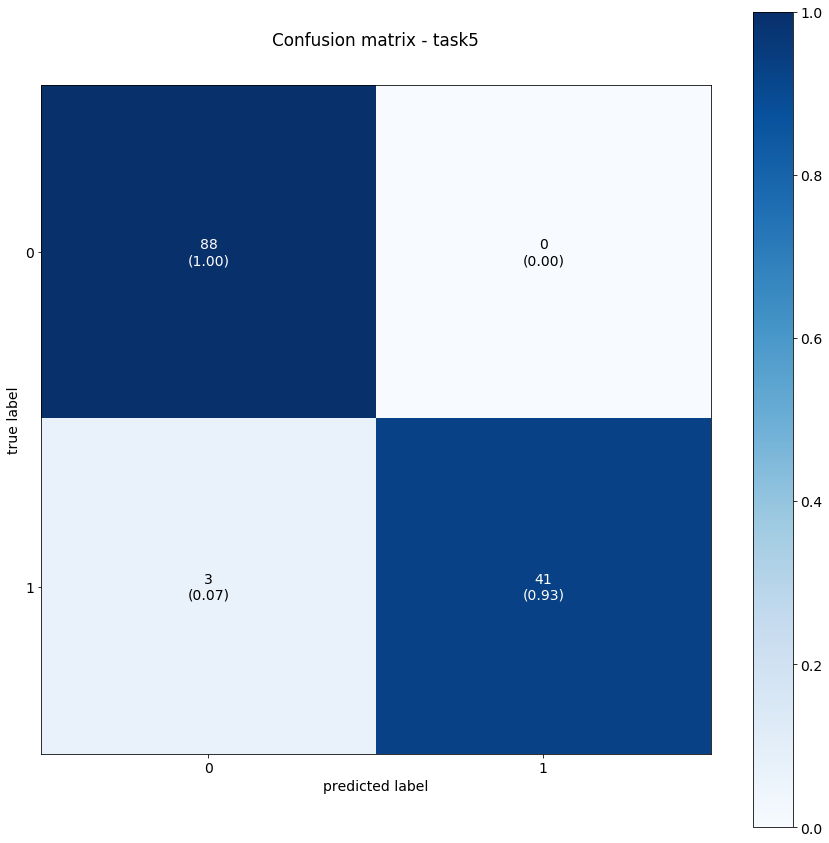

In [15]:
display_confusion_matrix(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [16]:
_,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
save_prediction(predict, filedir, taskname)
print(predict)

[0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0
 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1
 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0]
